In [239]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

### MNIST Dataset

In [240]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = torch.FloatTensor(x_train) / 255.
x_test = torch.FloatTensor(x_test) / 255.

y_train = torch.FloatTensor(y_train).long()
y_test = torch.FloatTensor(y_test).long()

y_train = torch.nn.functional.one_hot(y_train, num_classes=10)
y_test = torch.nn.functional.one_hot(y_test, num_classes=10)

x_train.shape, y_train.shape

(torch.Size([60000, 28, 28]), torch.Size([60000, 10]))

In [241]:
# Reshape the Tensor
x_train = x_train.view(-1, 1, 28, 28)
x_test = x_test.view(-1, 1, 28, 28)

y_train = y_train.view(-1, 10)
y_test = y_test.view(-1, 10)

x_train.shape, x_test.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

In [242]:
batch_size = 100

# Split the data and labels into batches
xtrain_batches = torch.split(x_train, batch_size)
ytrain_batches = torch.split(y_train, batch_size)

xtest_batches = torch.split(x_train, batch_size)
ytest_batches = torch.split(y_train, batch_size)

### Build CNN Model

In [243]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 5, 1, padding="same")
        self.conv2 = torch.nn.Conv2d(32, 64, 5, 1, padding="same")
        self.line1 = torch.nn.Linear(7*7*64, 1024)
        self.line2 = torch.nn.Linear(1024, 10)

    def forward(self, x):
        # Convolution Layer 1
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2, 2)

        # Convolution Layer 2
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2, 2)

        # Fully Connected Layer
        x = x.view(-1, 7*7*64)
        x = torch.nn.functional.relu(self.line1(x))
        x = torch.nn.functional.dropout(x, p=0.5)

        # Softmax Layer
        x = torch.nn.functional.softmax(self.line2(x), dim=1)

        return x

In [244]:
model = Model()

# Set Loss Function
criterion = torch.nn.CrossEntropyLoss()

# Set Optimizeer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [245]:
epochs = 5
losses = []

for i in range(epochs):
    for (x_batch, y_batch) in zip(xtrain_batches, ytrain_batches):
        # x_batch = x_batch.view(batch_size, 1, 28, 28)
        # y_batch = y_batch.view(batch_size, 10)

        # Predict the batch
        y_pred = model(x_batch)

        y_pred = y_pred.float()
        y_batch = y_batch.float()

        # Added the loss batch
        loss = criterion(y_pred, y_batch)
        losses.append(loss.detach().numpy)

        # Back Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
print(f"Epoch: {i+1} and Losses: {loss}")

Epoch: 5 and Losses: 1.4864498376846313


In [246]:
# Validation Test
with torch.no_grad():
    correct = 0

    for j, (x_batch, y_batch) in enumerate(zip(xtest_batches, ytest_batches)):
        # x_batch = x_batch.view(batch_size, 1, 28, 28)
        # y_batch = y_batch.view(batch_size, 10)

        # Predict the batch
        y_pred = model(x_batch)

        for pred, value in zip(y_pred, y_batch):
            if pred.argmax().item() == value.argmax().item():
                correct +=1

print(f"We got {round((correct)/((j+1)*batch_size)*100, 2)}% accuracy!")

We got 97.99% accuracy!


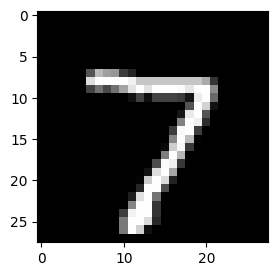

This is the number 7!


In [249]:
# Image Prediction
sampleimage = x_test[0]

plt.figure(1, figsize=(3,3))
plt.imshow(np.reshape(sampleimage,[28, 28]), cmap="gray")
plt.show()

print(f"This is the number {model(sampleimage).argmax().item()}!")